In [221]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import operator

In [333]:
def pre_process_image(img, skip_dilate=False):
    """Uses a blurring function, adaptive thresholding and dilation to expose the main features of an image."""

    # Gaussian blur with a kernal size (height, width) of 9.
    # Note that kernal sizes must be positive and odd and the kernel must be square.
    # proc = cv2.GaussianBlur(img.copy(), (9, 9), 0)

    # Adaptive threshold using 11 nearest neighbour pixels
    # proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    _, proc = cv2.threshold(img.copy(),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Invert colours, so gridlines have non-zero pixel values.
    # Necessary to dilate the image, otherwise will look like erosion instead.
    proc = cv2.bitwise_not(proc)

    # if not skip_dilate:
    #     # Dilate the image to increase the size of the grid lines.
    #     kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]], np.uint8)
    #     proc = cv2.dilate(proc, kernel)

    plt.imshow(proc, cmap='gray')
    plt.title('pre_process_image')
    plt.show()
    return proc

In [334]:
def find_corners_of_largest_polygon(img):
    """Finds the 4 extreme corners of the largest contour in the image."""
    contours, h = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Find contours
    contours = sorted(contours, key=cv2.contourArea, reverse=True)  # Sort by area, descending
    polygon = contours[0]  # Largest image

    # Use of `operator.itemgetter` with `max` and `min` allows us to get the index of the point
    # Each point is an array of 1 coordinate, hence the [0] getter, then [0] or [1] used to get x and y respectively.

    # Bottom-right point has the largest (x + y) value
    # Top-left has point smallest (x + y) value
    # Bottom-left point has smallest (x - y) value
    # Top-right point has largest (x - y) value
    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))

    # Return an array of all 4 points using the indices
    # Each point is in its own array of one coordinate
    return [polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]

In [335]:
def distance_between(p1, p2):
  x1, y1 = p1
  x2, y2 = p2
  dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
  return dist

def crop(img, crop_rect):
  top_left, bottom_right = crop_rect[0], crop_rect[2]
  
  x1, y1 = top_left
  x2, y2 = bottom_right

  crop = img[y1:y2, x1:x2]
  
  plt.imshow(crop, cmap='gray')
  plt.title('warp_image')
  plt.show()
  return crop

def crop_and_warp(img, crop_rect):
    """Crops and warps a rectangular section from an image into a square of similar size."""

    # Rectangle described by top left, top right, bottom right and bottom left points
    top_left, top_right, bottom_right, bottom_left = crop_rect[0], crop_rect[1], crop_rect[2], crop_rect[3]

    # Explicitly set the data type to float32 or `getPerspectiveTransform` will throw an error
    src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

    # Get the longest side in the rectangle
    side = max([
        distance_between(bottom_right, top_right),
        distance_between(top_left, bottom_left),
        distance_between(bottom_right, bottom_left),
        distance_between(top_left, top_right)
        ])

    # Describe a square with side of the calculated length, this is the new perspective we want to warp to
    dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')

    # Gets the transformation matrix for skewing the image to fit a square by comparing the 4 before and after points
    m = cv2.getPerspectiveTransform(src, dst)

    # Performs the transformation on the original image
    warp = cv2.warpPerspective(img, m, (int(side), int(side)))
    plt.imshow(warp, cmap='gray')
    plt.title('warp_image')
    plt.show()
    return warp

In [336]:
def nearest_num_div_by_9(x, d = 9):
  return (x + d) - (x % d)

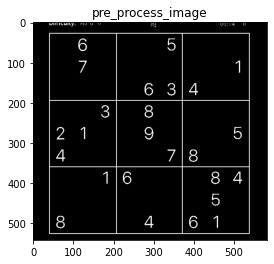

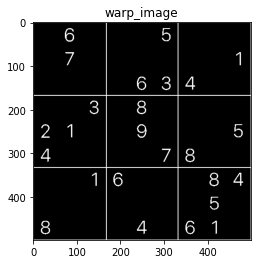

In [416]:
img = cv2.imread('hard2.png', cv2.IMREAD_GRAYSCALE)
img = pre_process_image(img)
crop_rect = find_corners_of_largest_polygon(img)
cropped = crop(img, crop_rect)

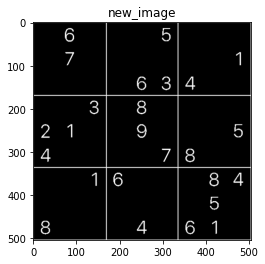

In [417]:
new_shape = nearest_num_div_by_9(cropped.shape[0])
new = cv2.resize(cropped, (new_shape,new_shape), interpolation = cv2.INTER_CUBIC)
plt.imshow(new, cmap='gray')
plt.title('new_image')
plt.show()

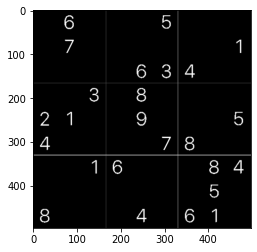

In [418]:
rows = []
for row in range(new.shape[0]):
  if new[row,:].sum() > (new_shape*255 * 0.5):
    rows.append(row)

cols = []
for col in range(new.shape[1]):
  if new[:,col].sum() > (new_shape*255 * 0.5):
    cols.append(col)

new_ = np.delete(new, rows, 1)
new_ = np.delete(new_, cols, 0)

plt.imshow(new_, cmap='gray')
plt.show()

In [419]:
divisor = new_.shape[0]//9

puzzle = []
for i in range(9):
    row = []
    for j in range(9):
        #slice image, reshape it to 28x28 (mnist reader size)
        block = cv2.resize(new_[i*divisor:(i+1)*divisor,
                                    j*divisor:(j+1)*divisor][3:-3, 3:-3], 
                              dsize=(28,28), 
                              interpolation=cv2.INTER_CUBIC)
        row.append(block)
    puzzle.append(row)

In [420]:
# from resnet164 import ResNet164
# model = ResNet164()
# model.compile()

# model.load_weights('/content/drive/MyDrive/MNIST_ResNet164.h5')

In [421]:
# import tensorflow as tf

# model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.Conv2D(254, kernel_size=(3,3), input_shape=(28,28, 1)))
# model.add(tf.keras.layers.MaxPool2D((2,2)))
# model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3)))
# model.add(tf.keras.layers.MaxPool2D((2,2)))
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(140, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.Dense(80, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.Dense(units=10, activation='sigmoid'))

# model.load_weights('/content/drive/MyDrive/image_to_number_model.hdf5')

# count = 0 
# for row in puzzle:
#     for spot in row:
#         if np.mean(spot) > 10:
#             count += 1
#             plt.imshow(spot)
#             plt.show()
#             print(model.predict_classes(spot.reshape(1,28,28,1).astype('float32')/255))
            
# print(count)

In [422]:
# count = 0 
# for row in puzzle:
#     for spot in row:
#         if np.mean(spot) > 10:
#             count += 1
#             plt.imshow(spot)
#             plt.show()

#             spot = normalize_images(spot.reshape(1,28,28,1))
#             print((model.predict(spot, verbose=0)[0]).argmax())
            
# print(count)

In [446]:
template = [
    [0 for _ in range(9)] for _ in range(9)
]

for i, row in enumerate(puzzle):
    for j, spot in enumerate(row):
        if np.mean(spot) > 6:
            spot = normalize_images(spot.reshape(1,28,28,1))
            template[i][j] = (model.predict(spot, verbose=0)[0]).argmax()

template

[[0, 6, 0, 0, 0, 5, 0, 0, 0],
 [0, 7, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 6, 3, 4, 0, 0],
 [0, 0, 3, 0, 8, 0, 0, 0, 0],
 [2, 1, 0, 0, 9, 0, 0, 0, 5],
 [4, 0, 0, 0, 0, 7, 8, 0, 0],
 [0, 0, 1, 6, 0, 0, 0, 8, 4],
 [0, 0, 0, 0, 0, 0, 0, 5, 0],
 [8, 0, 0, 0, 4, 0, 6, 1, 0]]

In [447]:
import numpy as np
import time

subtract_set = {1,2,3,4,5,6,7,8,9}

def check_horizontal(i,j):
    return subtract_set - set(container[i])

def check_vertical(i,j):
    ret_set = []
    for x in range(9):
        ret_set.append(container[x][j])
    return subtract_set - set(ret_set)

def check_square(i,j):
    first = [0,1,2]
    second = [3,4,5]
    third = [6,7,8]
    find_square = [first,second,third]
    for l in find_square:
        if i in l:
            row = l
        if j in l:
            col = l
    ret_set = []
    for x in row:
        for y in col:
            ret_set.append(container[x][y])
    return subtract_set - set(ret_set)

def get_poss_vals(i,j):
    poss_vals = list(check_square(i,j).intersection(check_horizontal(i,j)).intersection(check_vertical(i,j)))
    return poss_vals

def explicit_solver(container):
    stump_count = 1
    for i in range(9):
        for j in range(9):
            if container[i][j] == 0:
                poss_vals = get_poss_vals(i,j)
                if len(poss_vals) == 1:
                    container[i][j] = list(poss_vals)[0]
                    # print_container(container)
                    stump_count = 0
    return container, stump_count

def implicit_solver(i,j,container):
    if container[i][j] == 0:
        poss_vals = get_poss_vals(i,j)
        
        #check row
        row_poss = []
        for y in range(9):
            if y == j:
                continue
            if container[i][y] == 0:
                for val in get_poss_vals(i,y):
                    row_poss.append(val)
        if len(set(poss_vals)-set(row_poss)) == 1:
            container[i][j] = list(set(poss_vals)-set(row_poss))[0]
            # print_container(container)
        
        #check column
        col_poss = []
        for x in range(9):
            if x == i:
                continue
            if container[x][j] == 0:
                for val in get_poss_vals(x,j):
                    col_poss.append(val)
        if len(set(poss_vals)-set(col_poss)) == 1:
            container[i][j] = list(set(poss_vals)-set(col_poss))[0]
            # print_container(container)
                
        #check square
        first = [0,1,2]
        second = [3,4,5]
        third = [6,7,8]
        find_square = [first,second,third]
        for l in find_square:
            if i in l:
                row = l
            if j in l:
                col = l
        square_poss = []
        for x in row:
            for y in col:
                if container[x][y] == 0:
                    for val in get_poss_vals(x,y):
                        square_poss.append(val)
        if len(set(poss_vals)-set(square_poss)) == 1:
            container[i][j] = list(set(poss_vals)-set(square_poss))[0]
            # print_container(container)
    return container

def print_container(container):
    print("\n")
    for i in range(len(container)):
        line = ""
        if i == 3 or i == 6:
            print("---------------------")
        for j in range(len(container[i])):
            if j == 3 or j == 6:
                line += "| "
            line += str(container[i][j])+" "
        print(line)

In [448]:
# hardest_sudoku = [
#     [8,0,0,0,0,0,0,0,0],
#     [0,0,3,6,0,0,0,0,0],
#     [0,7,0,0,9,0,2,0,0],
#     [0,5,0,0,0,7,0,0,0],
#     [0,0,0,0,4,5,7,0,0],
#     [0,0,0,1,0,0,0,3,0],
#     [0,0,1,0,0,0,0,6,8],
#     [0,0,8,5,0,0,0,1,0],
#     [0,9,0,0,0,0,4,0,0]]
    
container = template

# using explicit solver
start = time.time()
zero_count = 0
for l in container:
    for v in l:
        if v == 0:
            zero_count += 1
            
print(f'There are {zero_count} moves I have to make!')

solving = True

while solving:
    #Solver Portion
    container, stump_count = explicit_solver(container)
    
    #Loop-Breaking Portion
    zero_count = 0
    for l in container:
        for v in l:
            if v == 0:
                zero_count += 1
    if zero_count==0:
        print_container(container)
        solving=False
    if stump_count > 0:
        for i in range(9):
            for j in range(9):
                container = implicit_solver(i,j,container)
print()
print('That took', time.time()-start, 'seconds!')

There are 56 moves I have to make!


9 6 2 | 4 1 5 | 3 7 8 
3 7 4 | 9 2 8 | 5 6 1 
1 8 5 | 7 6 3 | 4 2 9 
---------------------
7 5 3 | 2 8 4 | 1 9 6 
2 1 8 | 3 9 6 | 7 4 5 
4 9 6 | 1 5 7 | 8 3 2 
---------------------
5 3 1 | 6 7 2 | 9 8 4 
6 4 9 | 8 3 1 | 2 5 7 
8 2 7 | 5 4 9 | 6 1 3 

That took 0.02454519271850586 seconds!


In [ ]:
hardest_sudoku = [
    [8,0,0,0,0,0,0,0,0],
    [0,0,3,6,0,0,0,0,0],
    [0,7,0,0,9,0,2,0,0],
    [0,5,0,0,0,7,0,0,0],
    [0,0,0,0,4,5,7,0,0],
    [0,0,0,1,0,0,0,3,0],
    [0,0,1,0,0,0,0,6,8],
    [0,0,8,5,0,0,0,1,0],
    [0,9,0,0,0,0,4,0,0]]

mySudoku = Sudoku( hardest_sudoku )
start = time.time()
mySudoku.solve( "A", "0", time.time(), False )
print( "solved in {} seconds".format( time.time() - start ) )